Epoch 1/20, Loss: 2.6223
Epoch 2/20, Loss: 1.5462
Epoch 3/20, Loss: 1.1163
Epoch 4/20, Loss: 0.8524
Epoch 5/20, Loss: 0.6492
Epoch 6/20, Loss: 0.4859
Epoch 7/20, Loss: 0.3183
Epoch 8/20, Loss: 0.2262
Epoch 9/20, Loss: 0.1595
Epoch 10/20, Loss: 0.1142
Epoch 11/20, Loss: 0.1060
Epoch 12/20, Loss: 0.1074
Epoch 13/20, Loss: 0.1095
Epoch 14/20, Loss: 0.1334
Epoch 15/20, Loss: 0.1229
Epoch 16/20, Loss: 0.1081
Epoch 17/20, Loss: 0.0918
Epoch 18/20, Loss: 0.0661
Epoch 19/20, Loss: 0.0517
Epoch 20/20, Loss: 0.0398


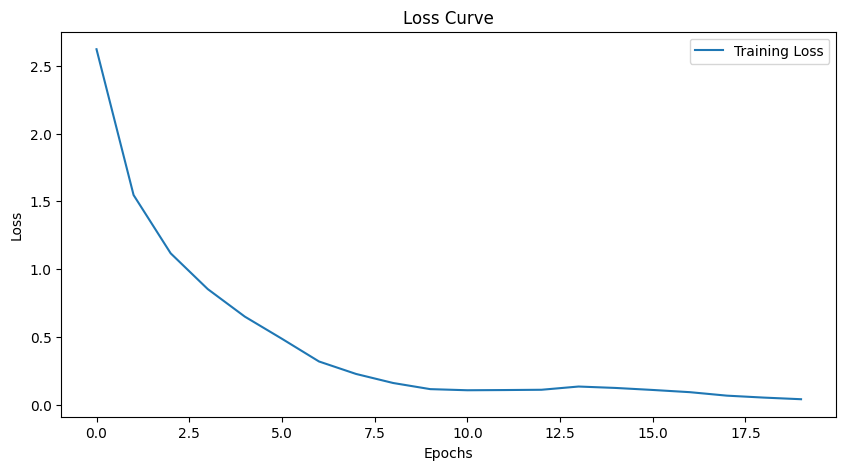

Evaluation Loss: 0.0365


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate synthetic dataset
def generate_data(n_samples, seq_length, vocab_size):
    source_sequences = np.random.randint(1, vocab_size, (n_samples, seq_length))
    # Create a copy of the source_sequences before flipping to avoid negative strides
    target_sequences = np.flip(source_sequences.copy(), axis=1)
    return source_sequences, target_sequences

n_samples = 10000
seq_length = 10
vocab_size = 50
source_sequences, target_sequences = generate_data(n_samples, seq_length, vocab_size)

# Define Dataset and DataLoader
class Seq2SeqDataset(torch.utils.data.Dataset):
    def __init__(self, source_sequences, target_sequences):
        self.source_sequences = source_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.source_sequences)

    def __getitem__(self, idx):
        # Create a copy of the target sequence to avoid negative strides
        return torch.tensor(self.source_sequences[idx], dtype=torch.long), torch.tensor(self.target_sequences[idx].copy(), dtype=torch.long)

dataset = Seq2SeqDataset(source_sequences, target_sequences)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

# Define Attention
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.shape[1]
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return torch.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], dim=2)))
        energy = energy.transpose(2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

# Define Decoder with Attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True) # Define the RNN layer
        self.fc = nn.Linear(hidden_dim, vocab_size) # Define the fully connected layer

    def forward(self, x, hidden, encoder_outputs): # Define the forward method
        embedded = self.embedding(x.unsqueeze(1))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden

# Define Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        vocab_size = self.decoder.fc.out_features # Access the output features of the fully connected layer

        outputs = torch.zeros(batch_size, target_len, vocab_size).to(device)
        encoder_outputs, hidden = self.encoder(source)

        input = target[:, 0]
        for t in range(1, target_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs) # Call the decoder's forward method
            outputs[:, t] = output
            teacher_force = np.random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = target[:, t] if teacher_force else top1

        return outputs

# Initialize the model, loss function, and optimizer
embedding_dim = 256
hidden_dim = 512

encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Training the model
n_epochs = 20
train_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(source, target)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        target = target[:, 1:].reshape(-1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(dataloader))
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss / len(dataloader):.4f}')

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Evaluate the model performance
def evaluate(model, dataloader):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)
            output = model(source, target, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            target = target[:, 1:].reshape(-1)
            loss = criterion(output, target)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

eval_loss = evaluate(model, dataloader)
print(f'Evaluation Loss: {eval_loss:.4f}')


In [ ]:
# Function to calculate accuracy
def calculate_accuracy(predictions, targets):
    """
    Calculate the accuracy of the model predictions.
    :param predictions: The predicted sequences.
    :param targets: The target sequences.
    :return: Accuracy as a percentage.
    """
    # Remove the <sos> token from the targets and predictions
    targets = targets[:, 1:]
    predictions = predictions[:, 1:]

    # Get the predicted token indices
    top_predictions = predictions.argmax(2)

    # Compare predictions with targets
    correct = (top_predictions == targets).float()

    # Calculate accuracy
    accuracy = correct.sum() / torch.numel(correct)
    return accuracy * 100

# Evaluate the model accuracy
def evaluate_accuracy(model, dataloader):
    model.eval()
    total_accuracy = 0

    with torch.no_grad():
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)
            output = model(source, target, teacher_forcing_ratio=0)
            total_accuracy += calculate_accuracy(output, target).item()

    return total_accuracy / len(dataloader)

accuracy = evaluate_accuracy(model, dataloader)
print(f'Model Accuracy: {accuracy:.2f}%')


Model Accuracy: 99.52%


In [ ]:
import joblib
from google.colab import files

# Define the path to save the model
model_path = "Seq2Seq_model.pkl"

# Save the model
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

# Download the file
files.download(model_path)


Model saved to Seq2Seq_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>